In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt

In [2]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f' % err)

def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)
    
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = [int(x) for x in (pred_train_i != Y_train)]
        # Equivalent with 1/-1 to update weights
        miss2 = [x if x==1 else -1 for x in miss]
        # Error
        err_m = np.dot(w,miss) / sum(w)
        # Alpha
        alpha_m = 0.5 * np.log( (1 - err_m) / float(err_m))
        # New weights
        w = np.multiply(w, np.exp([float(x) * alpha_m for x in miss2]))
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), \
           get_error_rate(pred_test, Y_test)

def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')

C:\Users\Ast\AppData\Local\Temp\ipykernel_1744\1517928280.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot1.set_xticklabels(range(0,450,50))


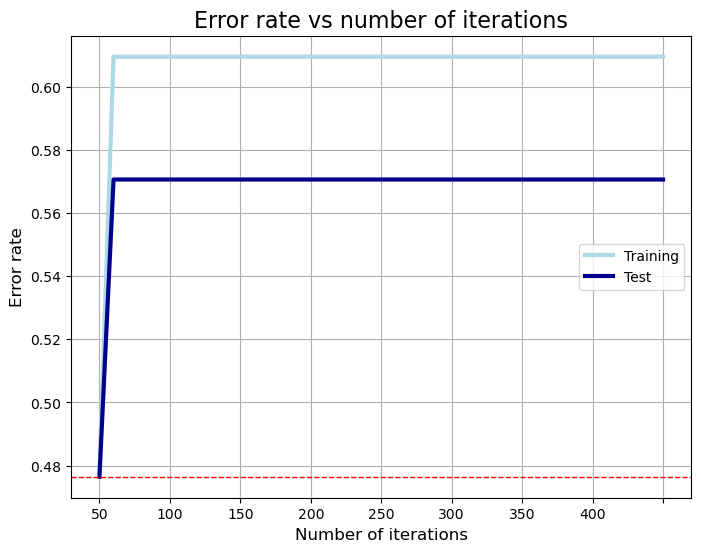

In [3]:
   
# Read data
data = pd.read_csv('datasets/vehicle_csv.csv')
y = data['Class']
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
X = data.loc[:, 'COMPACTNESS':'HOLLOWS_RATIO']

# X, y = make_hastie_10_2()

data_glass = pd.read_csv('datasets/glass.csv')
y_glass = data_glass['Type']
X_glass = data_glass.loc[:, 'RI':'Fe']

# Split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2)

# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 2, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)

clf_KNN = KNeighborsClassifier(n_neighbors=len(Y_train) - 1, weights='distance')
er_KNN = generic_clf(Y_train, X_train, Y_test, X_test, clf_KNN)

# Fit Adaboost classifier using a decision tree as base estimator
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 410, 10)
for i in x_range:    
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])

# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)